In [22]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [23]:
train_dataset = 'data/train.csv'
test_dataset = 'data/test.csv'
model_save_path = 'model/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier.tflite'
xgb_save_path = 'model/keypoint_classifier.pkl'

# Set number of classes

In [24]:
NUM_CLASSES = 32

# Dataset reading

In [25]:
X_train = np.loadtxt(train_dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_test = np.loadtxt(test_dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [26]:
print(X_train[0].shape)

(42,)


In [27]:
y_train = np.loadtxt(train_dataset, delimiter=',', dtype='int32', usecols=(0))
y_test = np.loadtxt(test_dataset, delimiter=',', dtype='int32', usecols=(0))

In [28]:
X_train = np.array(X_train)
print(X_train.shape)

(9554, 42)


In [6]:
# X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [36]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0]
}

xgb_model = XGBClassifier()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
model = XGBClassifier(**best_params)
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Input((21 * 2, )),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(20, activation='relu'),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(10, activation='relu'),
#     tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
# ])



# Model training

In [55]:
model.fit(
    X_train,
    y_train,
    # epochs=1000,
    # batch_size=128,
    # validation_data=(X_test, y_test),
    # callbacks=[cp_callback, es_callback]
    # eval_metric='error'
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [48]:
# Model evaluation
# val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

model.score(X_test, y_test)

Accuracy: 0.785956416464891


0.785956416464891

In [46]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)


In [49]:
# Inference test
predict_result = model.predict([X_test[0]])
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

0
0


# Confusion matrix

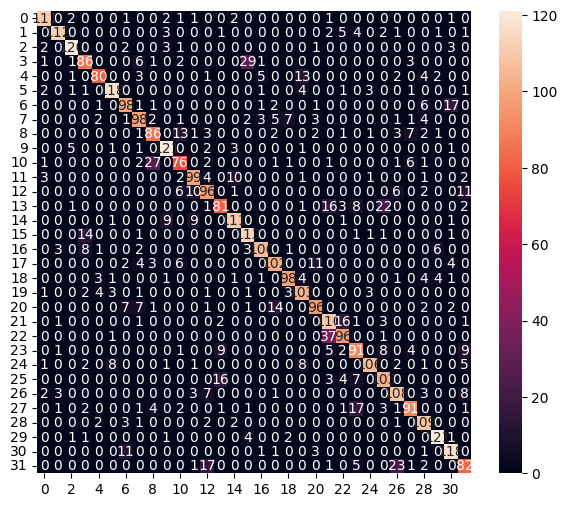

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       122
           1       0.93      0.85      0.89       132
           2       0.91      0.91      0.91       132
           3       0.74      0.66      0.70       130
           4       0.86      0.72      0.78       111
           5       0.89      0.89      0.89       133
           6       0.78      0.77      0.77       128
           7       0.75      0.75      0.75       130
           8       0.69      0.70      0.69       123
           9       0.86      0.90      0.88       135
          10       0.68      0.64      0.66       119
          11       0.79      0.80      0.80       123
          12       0.70      0.73      0.71       132
          13       0.74      0.60      0.66       135
          14       0.85      0.84      0.85       132
          15       0.73      0.86      0.79       132
          16       0.89      0.82      0.85       130
     

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
# y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, Y_pred)

# Convert to model for Tensorflow-Lite

In [52]:
# Save as a model dedicated to inference
model.save(model_save_path)

AttributeError: 'XGBClassifier' object has no attribute 'save'

In [18]:
# Transform model (quantization)
converter = tf.lite.TFLiteConverter.from_saved_model(xgboost_model_path ) 
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\o\AppData\Local\Temp\tmp6trag3oh\assets


INFO:tensorflow:Assets written to: C:\Users\o\AppData\Local\Temp\tmp6trag3oh\assets


7804

# Inference test

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [20]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[7.0431352e-01 4.8553960e-07 3.7069969e-02 2.6586056e-10 1.7369844e-04
 9.6238581e-03 5.2038712e-07 2.0727679e-05 4.6420118e-05 2.0710965e-01
 8.7337487e-04 8.1806583e-03 1.0825241e-03 5.1456359e-06 2.6830476e-02
 4.8275794e-08 4.6460347e-10 6.3444480e-07 1.6511109e-04 4.4670692e-04
 3.1576394e-06 3.9811548e-05 6.9910304e-05 2.1582565e-07 1.5972896e-03
 8.1855585e-05 5.3947151e-04 3.1367694e-07 7.7522034e-04 4.8180818e-06
 2.6214025e-08 9.4428431e-04]
0
CPU times: total: 0 ns
Wall time: 1 ms
